# Image Classification Improved model
13May2023 Li-Hsin Liang

In [1]:
# Import relevant library
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
# Access data
import pathlib
data_dir_path = "data/yoga_poses"
data_dir = pathlib.Path(data_dir_path)

In [3]:
# Count the data volume
# '*/*.jpg' this is to check all the file even in the sub-folder with .jpg at the end.
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

630


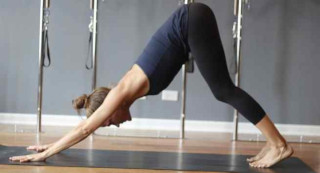

In [4]:
# Display downward Dog image
downdog = list(data_dir.glob('downdog/*'))
PIL.Image.open(str(downdog[0]))

In [5]:
# Build model

batch_size = 32
img_height = 180
img_width = 180

# data split
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

class_names = train_ds.class_names
num_classes = len(class_names)

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal",
                          input_shape=(img_height,
                                       img_width,
                                       3)),
        layers.RandomRotation(0.05),
        layers.RandomZoom(0.1),
    ]
)

model = Sequential([
    # add augmented data
    data_augmentation,
    # data normalisation
    layers.Rescaling(1./255),
    # 1st convolutional block
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    # 2nd convolutional block
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    # 3rd convolutional block
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    # 4th convolutional block
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    # add dropout
    layers.Dropout(0.3),
    # fully-connected layer
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, name="outputs")
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

epochs = 15
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Found 630 files belonging to 5 classes.
Using 504 files for training.
Found 630 files belonging to 5 classes.
Using 126 files for validation.
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-05-19 18:58:51.445268: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        9280      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                  

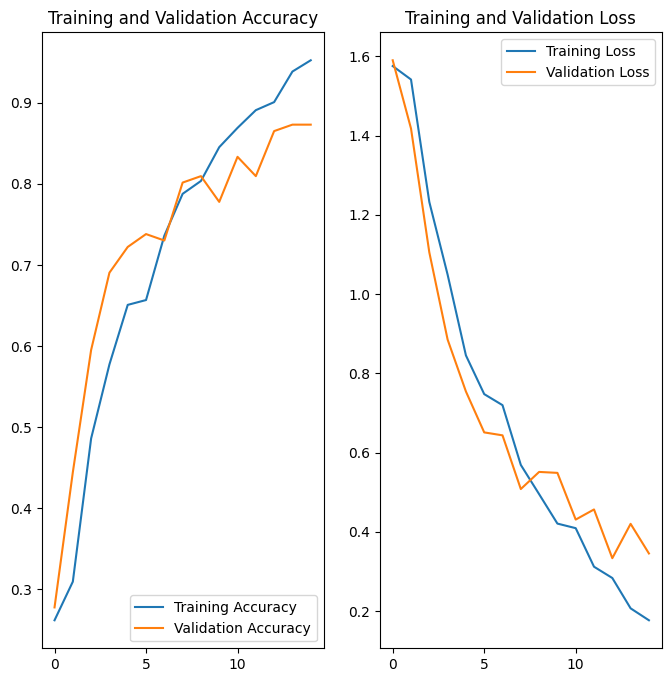

In [6]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Test the model

the improved model predict the following poses **correct**

|   Poses   | Confidence |
|:---------:|-----------:|
|  downdog  |     99.84% |
| warrior2  |     94.92% |


predict the following poses **incorrect**


| Poses      | Confidence         |
|:-----------|:-------------------|
| plank      | 59.23% as downdog  |
| tree       | 60.49% as downdog  |
| goddess    | 77.48% as warrior2 |
| wrong data | 81.82% as plank    |

In [28]:
downdog_path = "data/sample/downdog/IMG_0001.jpeg"
plank_path = "data/sample/plank/IMG_0002.jpeg"
tree_path = "data/sample/tree/IMG_9996.jpeg"
warrior2_path = "data/sample/warrior2/IMG_0020.jpeg"
goddess_path = "data/sample/goddess/IMG_9992.jpeg"
wrong_data_path = "data/sample/wrong_data/IMG_0065.jpeg"

img = tf.keras.utils.load_img(
    tree_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 13ms/step
This image most likely belongs to downdog with a 60.49 percent confidence.


In [29]:
#perdiction for each poses
print(class_names)
for num in predictions:
    print(num)

['downdog', 'goddess', 'plank', 'tree', 'warrior2']
[ 6.768352    3.1427906  -0.12134349  4.0052567   6.1928105 ]
